# Drone Trajectory Optimization using Optimica

## Define optimization problem
    In this part, we will write the optimica code to syntesize the optimization problem.

In [1]:
%%writefile Drone_TorqueInput.mo
model Drone_TorqueInput

    // The drone parameters
    parameter Real Np=4 "Propeller number";
    parameter Real M=1.3 "Drone mass";
    parameter Real beta=0.34 "Pitch angle coefficient";
    parameter Real Ct0=0.02791+0.11867*beta+0.27334*beta^2 - 0.28852*beta^3 "Static Thrust coefficient";
    parameter Real Cp0=0.01813-0.06218*beta+0.35712*beta^2 - 0.23774*beta^3 "Static Power coefficient";
    parameter Real Rho=1.18 "Air mass volumic";
    parameter Real d=10*0.0254 "Propeller diameter";
    parameter Real S=0.4*0.4 "Surface";
    parameter Real Cd=1 "Drag coefficient";
    parameter Real J_pro=1e-4 "Propeller inertia";
    parameter Real K_mot=(1./760.) * 60./2./3.14 "[V/(rad/s)] Motor torque coeff";
    parameter Real R_mot = 0.26 "[Ohm] Motor resistance";
    parameter Real g=9.81 "Gravity coeffcient";

    // The mission parameters
    parameter Real H=10 "Height";
    //
    parameter Real n_hover=sqrt(M*g/Rho/Ct0/d^4/Np) "Hover rotational speed";
    parameter Real T_hover=Rho*Cp0*n_hover^2*d^5/(2*3.14) "Hover motor torque";


    // Aero coefficient
    Real Ct "Thrust coefficient";
    Real Cp "Power coefficient";
    Real J "Advance ratio";

    // The states
    Real xp "Speed";
    Real x "Position";
    // The force and power
    Real F "Propeller force";
    Real P(min=0) "Propeller power";
    Real E(min=0) "Propeller energy";
    Real n "Propeller speed (Hz)";
    Real w "Motor speed (rad/s)";
    Real Pmot "Motor losses";

    // Constraints variable

  input Real T
    annotation (Placement(transformation(extent={{-120,-60},{-80,-20}})));
  Real Speed
    annotation (Placement(transformation(extent={{90,-10},{110,10}})));
  Real Position
    annotation (Placement(transformation(extent={{90,-50},{110,-30}})));
  Real Power
    annotation (Placement(transformation(extent={{90,-90},{110,-70}})));
  Real Acceleration
    annotation (Placement(transformation(extent={{90,30},{110,50}})));
  Real Energy
    annotation (Placement(transformation(extent={{90,70},{110,90}})));

equation
    // Advance ratio
    J=xp/n/d;

    // C_t and C_d for APC props in dynamics
    Ct=0.02791-0.06543*J+0.11867*beta+0.27334*beta^2 - 0.28852*beta^3 + 0.02104
    *J^3 - 0.23504*J^2 + 0.18677*beta*J^2;
    Cp=0.01813-0.06218*beta+0.00343*J+0.35712*beta^2 - 0.23774*beta^3 + 0.07549
    *beta*J - 0.1235*J^2;

    // Mechanical equations
    der(x) = xp; // speed
    F=Rho*Ct*n^2*d^4*Np; // Propellers force
    M*der(xp) = F -1/2*Cd*S*xp* xp / sqrt(xp^2 + (1e-3)^2) -M*g; // PFD
    P=Rho*Ct*n^3*d^5*Np; //Propellers power
    J_pro*der(w)=T-Rho*Cp*n^2*d^5/(2*3.14); // Motor torque
    w=n*2*3.14; // Speeds
    Pmot=R_mot*(T/K_mot)^2; // Motor losses
    der(E) = P;

    //Output
    Acceleration=der(xp);
    Speed=xp;
    Position=x;
    Power=P+Np*Pmot;
    Energy=E;
    
  annotation (Icon(coordinateSystem(preserveAspectRatio=false), graphics={
        Rectangle(
          extent={{-78,0},{80,-80}},
          lineColor={28,108,200},
          fillPattern=FillPattern.VerticalCylinder,
          fillColor={255,0,0}),
        Ellipse(
          extent={{-100,40},{0,20}},
          lineColor={28,108,200},
          fillPattern=FillPattern.HorizontalCylinder,
          fillColor={255,0,0}),
        Ellipse(
          extent={{0,40},{100,20}},
          lineColor={28,108,200},
          fillPattern=FillPattern.HorizontalCylinder,
          fillColor={255,0,0}),
        Rectangle(
          extent={{-4,30},{4,0}},
          lineColor={28,108,200},
          fillPattern=FillPattern.VerticalCylinder,
          fillColor={255,0,0}),
        Text(
          extent={{-120,12},{-84,-24}},
          lineColor={28,108,200},
          fillPattern=FillPattern.VerticalCylinder,
          fillColor={255,0,0},
          textString="T")}),                                     Diagram(
        coordinateSystem(preserveAspectRatio=false)));
end Drone_TorqueInput;

Overwriting Drone_TorqueInput.mo


In [2]:
%%writefile Simu_Init.mo
model Simu_Init
    Drone_TorqueInput drone;

  Real T;
    
equation
    T = drone.T;
    drone.Position = (if time < 0.2 then 0 else if time < (0.2 + 4.6) then (time - 0.2)*10/4.6 else 10);
end Simu_Init;

Overwriting Simu_Init.mo


L'objectif est de minimiser l'energie consommée pour un vol de 5 s et avec les contraintes suivantes:
- la vitesse finale du drone doit etre nulle
- la position finale doit valoir 10m
- la vitesse de rotation moteur finale du drone doit permettre d'assurer le hover

Les position et vitesses initiales doivent être nulle mais c'est spécifié dans le modèle Modelica.

In [3]:
%%writefile OptimTraj.mop
optimization OptimTraj (objective=drone.Energy(finalTime), startTime=0, finalTime=5)
    Drone_TorqueInput drone(n(start=drone.n_hover,fixed=true));

  Modelica.Blocks.Interfaces.RealInput T
    annotation (Placement(transformation(extent={{-120,-60},{-80,-20}})));
    
equation
    T = drone.T;
constraint
    drone.n(startTime) = drone.n_hover;
    drone.Position(startTime) = 0;
    drone.Position(finalTime) = 10;
    drone.Speed(startTime) = 0;
    drone.Speed(finalTime) = 0;
    drone.Acceleration(startTime) = 0;
    drone.Acceleration(finalTime) = 0;
end OptimTraj;

Overwriting OptimTraj.mop


In [4]:
from pymodelica import compile_fmu
from pyfmi import load_fmu
from pyjmi import transfer_optimization_problem
# Import the plotting library
import matplotlib.pyplot as plt

In [5]:
init_model_name = 'Drone_Simu_Position.mo'
import os
cwd = os.getcwd()
lib = cwd#[os.path.join(cwd, init_model_name)]
fmu = compile_fmu('Simu_Init', ['Simu_Init.mo', 'Drone_TorqueInput.mo'])
model_init = load_fmu(fmu)
init_res = model_init.simulate()

Final Run Statistics: --- 

 Number of steps                                 : 506
 Number of function evaluations                  : 514
 Number of Jacobian evaluations                  : 9
 Number of function eval. due to Jacobian eval.  : 9
 Number of error test failures                   : 0
 Number of nonlinear iterations                  : 506
 Number of nonlinear convergence failures        : 0
 Number of time events                           : 1

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1.0000000000000002e-06
 Tolerances (relative)    : 0.0001

Simulation interval    : 0.0 - 1.0 seconds.
Elapsed simulation time: 0.02522910000000067 seconds.


In [6]:
# Transfer the optimization problem to casadi
op = transfer_optimization_problem("OptimTraj", ["OptimTraj.mop","Drone_TorqueInput.mo"], compiler_log_level='debug')
opts = op.optimize_options()
opts["n_cp"] = 3
opts["n_e"] = 10
opts["init_traj"] = init_res
opts["nominal_traj"] = init_res
opts['IPOPT_options']['tol'] = 1e-10
#print(opts["solver"])

In [7]:
res = op.optimize(options=opts)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.4, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:     1769
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      217

Total number of variables............................:      625
                     variables with only lower bounds:       71
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      599
Total number of inequality constrai

In [8]:
t = res['time']
x = res['drone.x']
xp = res['drone.xp']
n = res['drone.n']
T = res['drone.T']
E = res['drone.Energy']
A = res['drone.Acceleration']
print(f"Energy at the end of the trajectory is {round(E[-1], 2)} Joules")

Energy at the end of the trajectory is 1486.14 Joules


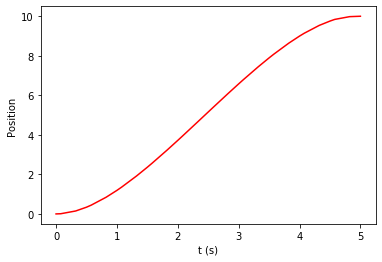

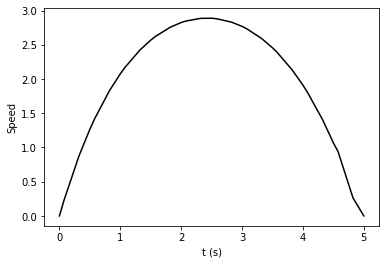

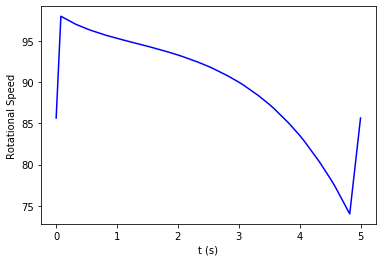

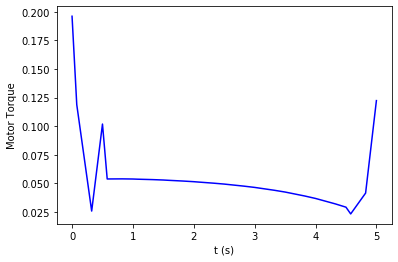

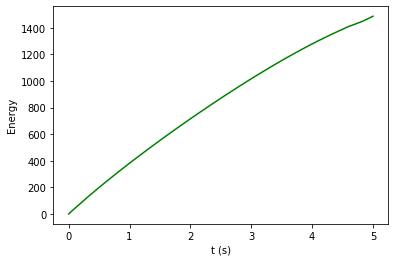

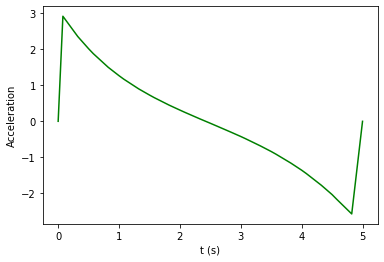

In [9]:
import matplotlib.pyplot as plt
plt.plot(t,x,'r')
plt.ylabel('Position')
plt.xlabel('t (s)')
plt.show()
plt.plot(t, xp,'k')
plt.ylabel('Speed')
plt.xlabel('t (s)')
plt.show()
plt.plot(t,n,'b')
plt.ylabel('Rotational Speed')
plt.xlabel('t (s)')
plt.show()
plt.plot(t,T,'b')
plt.ylabel('Motor Torque')
plt.xlabel('t (s)')
plt.show()
plt.plot(t,E,'g')
plt.ylabel('Energy')
plt.xlabel('t (s)')
plt.show()
plt.plot(t,A,'g')
plt.ylabel('Acceleration')
plt.xlabel('t (s)')
plt.show()